# Imports

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt

# Pre-Processing

In [5]:
# Load and combine data
PATH_TO_FILE_1 = "../raw data/aapl_2016_2020.csv"
PATH_TO_FILE_2 = "../raw data/aapl_2021_2023.csv"
half_1 = pd.read_csv(PATH_TO_FILE_1, low_memory=False)
half_2 = pd.read_csv(PATH_TO_FILE_2, low_memory=False)
df = pd.concat([half_1, half_2], ignore_index=True)
df.columns = df.columns.str.strip()

# Option type
option_type = "call"

# Convert Unix timestamps to datetime
df['QUOTE_DATETIME'] = pd.to_datetime(df['[QUOTE_UNIXTIME]'], unit='s')
df['EXPIRE_DATETIME'] = pd.to_datetime(df['[EXPIRE_UNIX]'], unit='s')

# Load underlying price data for volatility computation
underlying_prices = df[['QUOTE_DATETIME', '[UNDERLYING_LAST]']].drop_duplicates().set_index('QUOTE_DATETIME').sort_index()

# Function to compute historical volatility
def historical_volatility(series, window=20):
    return np.sqrt(252) * series.pct_change().rolling(window=window).std()

# Compute 20-day historical volatility
underlying_prices['hist_vol_20d'] = historical_volatility(underlying_prices['[UNDERLYING_LAST]'])
underlying_prices.dropna(inplace=True)

# Merge historical volatility back into main dataframe
df = df.merge(underlying_prices[['hist_vol_20d']], left_on='QUOTE_DATETIME', right_index=True, how='inner')

# Columns to numeric conversion: choose columns based on option type
if option_type == 'call':
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
                    '[C_THETA]', '[C_RHO]', '[C_BID]', '[C_ASK]']
else:
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]',
                    '[P_THETA]', '[P_RHO]', '[P_BID]', '[P_ASK]']

essential_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d', '[C_BID]', '[C_ASK]']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=essential_cols, inplace=True)

# Calculate mid-price based on option type
if option_type == 'call':
    df['CALL_EQUI_PRICE'] = (df['[C_BID]'] + df['[C_ASK]']) / 2
else:
    df['PUT_EQUI_PRICE'] = (df['[P_BID]'] + df['[P_ASK]']) / 2

# Drop rows with missing essential data (dynamically chosen based on option type)
essential_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d']
if option_type == 'call':
    essential_cols.append('CALL_EQUI_PRICE')
else:
    essential_cols.append('PUT_EQUI_PRICE')
df.dropna(subset=essential_cols, inplace=True)

# Prepare option data based on the option type
if option_type == 'call':
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]', '[C_THETA]', '[C_RHO]', 'CALL_EQUI_PRICE']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'equilibrium_price']
    output_file = 'processed_calls_data.csv'
    model_file = 'call-mlp1.h5'
else:
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]', '[P_THETA]', '[P_RHO]', 'PUT_EQUI_PRICE']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'equilibrium_price']
    output_file = 'processed_puts_data.csv'
    model_file = 'put-mlp1.h5'

option_df = df[option_cols].copy()
option_df.columns = col_rename

# Normalize strike price and compute time to expiry in years
option_df['strike_price'] = option_df['strike_price'] / 1000
option_df['time_to_expiry'] = option_df['days_to_expiry'] / 365
option_df.drop('days_to_expiry', axis=1, inplace=True)

print(option_df.sample(10))

         underlying_price  strike_price  hist_volatility    delta    gamma  \
1020405            147.02        0.1700         0.385578  0.40081  0.00892   
463782             167.96        0.0450         0.166906  0.84606  0.00001   
898426             166.87        0.1350         0.200893  1.00000  0.00000   
157236             123.25        0.2250         0.247939  0.04869  0.00251   
695125             112.11        0.1030         0.202977  0.94187  0.00938   
979529             460.03        0.3100         0.496036  0.84507  0.00084   
546928             190.89        0.1900         0.157796  0.54535  0.03901   
1335101            142.80        0.0600         0.197134  0.86801  0.00009   
1030873            151.55        0.1490         0.224935  0.59025  0.02423   
743444              96.76        0.0865         0.258076  1.00000  0.00000   

            vega    theta       rho  equilibrium_price  time_to_expiry  
1020405  0.55112 -0.02784   0.45582             10.525        0.9397

# Hyperparameters

In [6]:
# Hyperparameters
n_units_per_layer = [256, 32, 1]
layers = 3
n_batch = 1024
n_epochs = 50

# Building model

In [7]:
# Prepare data for modeling
X = option_df[['underlying_price', 'strike_price', 'hist_volatility', 'delta', 'gamma', 'vega', 'theta', 'rho', 'time_to_expiry']]
y = option_df['equilibrium_price']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create model 
model = Sequential()


# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add first layer without ativation
model.add(Dense(n_units_per_layer[0], input_shape=(X_train_scaled.shape[1],)))
model.add(Activation('relu'))

# Define Keras MLP model using LeakyReLU in subsequent layers
for i in range(1, layers - 1):
    model.add(Dense(n_units_per_layer[i]))
    model.add(Activation('relu'))

# Add last layer
model.add(Dense(n_units_per_layer[-1]))
model.add(Activation('relu'))

# Learning rate scheduling
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.1  # reduce LR by 10x every 10 epochs
    return lr

lr_callback = LearningRateScheduler(scheduler)

early_stop = EarlyStopping(
    monitor='val_loss',       # what to monitor
    patience=5,               # how many epochs to wait before stopping
    restore_best_weights=True,  # restores weights from best epoch
    verbose=1
)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,817 (42.25 KB)

 Trainable params: 10,817 (42.25 KB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [35]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=n_batch, validation_split=0.2, verbose=1, callbacks=[lr_callback, early_stop])

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {mae}")

# Save the model
model.save(model_file)

Epoch 1/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 964.6230 - mae: 13.6452 - val_loss: 3.0790 - val_mae: 1.1061 - learning_rate: 0.0010
Epoch 2/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6403 - mae: 0.9618 - val_loss: 1.8566 - val_mae: 0.6823 - learning_rate: 0.0010
Epoch 3/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7386 - mae: 0.6311 - val_loss: 1.1885 - val_mae: 0.4847 - learning_rate: 0.0010
Epoch 4/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1653 - mae: 0.4599 - val_loss: 0.9821 - val_mae: 0.4055 - learning_rate: 0.0010
Epoch 5/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9109 - mae: 0.3788 - val_loss: 0.7839 - val_mae: 0.3359 - learning_rate: 0.0010
Epoch 6/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9095 - mae: 0.3364 - val_loss: 0.7578 - val_mae: 0.3273 - learning_rate: 0.0010
Epoch 7/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7017 - mae: 0.3035 - val_loss: 0.6686 - val_mae: 0.2752 - learning_ra

Test MAE: 0.19785672426223755


# Plot the loss

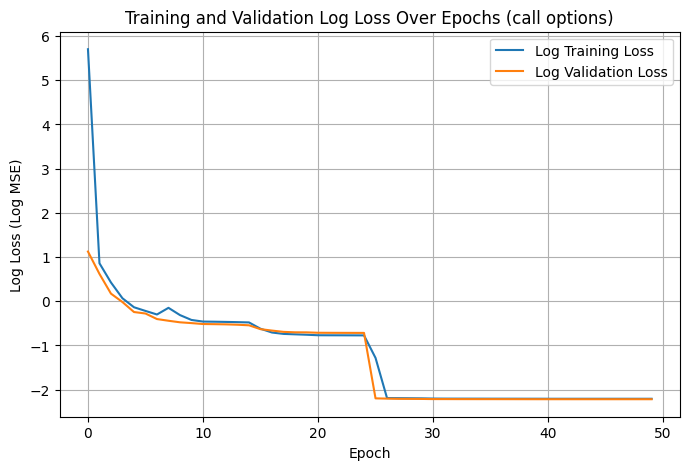

In [36]:
# Plot training and validation loss
plt.figure(figsize=(8,5))

eps = 1e-10  # tiny number to avoid log(0)
plt.plot(np.log(np.array(history.history['loss']) + eps), label='Log Training Loss')
plt.plot(np.log(np.array(history.history['val_loss']) + eps), label='Log Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss (Log MSE)')
plt.title(f'Training and Validation Log Loss Over Epochs ({option_type} options)')
plt.legend()
plt.grid(True)
plt.show()

# Plot results

4843/4843 ━━━━━━━━━━━━━━━━━━━━ 2s 335us/step


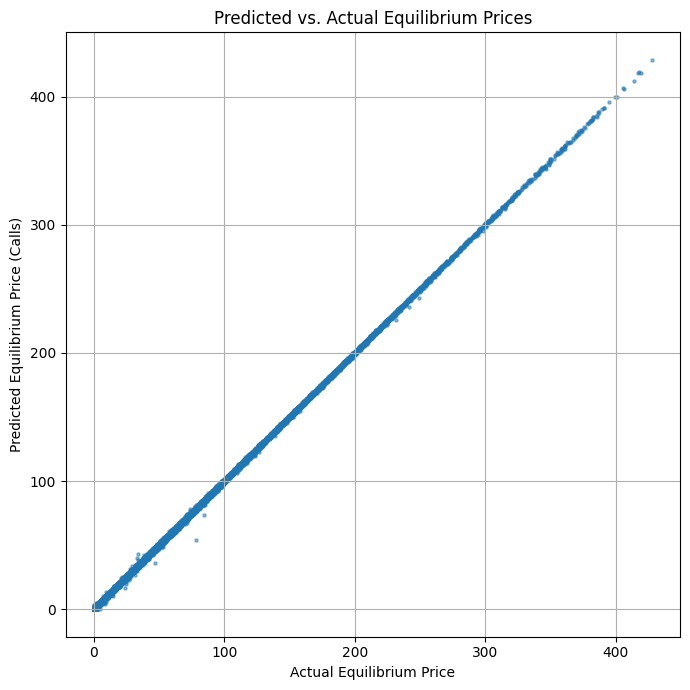

In [43]:
loaded_model = load_model(model_file)

# Predict on test set
y_pred = model.predict(X_test_scaled).flatten()

# Align y_test to numpy array with matching shape
y_test_array = y_test.to_numpy().flatten()

# Plot predicted vs actual
plt.figure(figsize=(7, 7))
plt.scatter(y_test_array, y_pred, s=5, alpha=0.5)
plt.xlabel('Actual Equilibrium Price')
plt.ylabel('Predicted Equilibrium Price (Calls)')
plt.title('Predicted vs. Actual Equilibrium Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

# Test random entries

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Entry 689362 - Predicted price: 0.00, Actual price: 0.02
Entry 797260 - Predicted price: 2.28, Actual price: 2.08
Entry 178106 - Predicted price: 0.48, Actual price: 0.81
Entry 1452010 - Predicted price: 10.87, Actual price: 10.97
Entry 841308 - Predicted price: 48.55, Actual price: 48.58
Entry 12905 - Predicted price: 7.20, Actual price: 7.70
Entry 234534 - Predicted price: 2.55, Actual price: 2.57
Entry 144971 - Predicted price: 156.81, Actual price: 156.80
Entry 1190921 - Predicted price: 2.12, Actual price: 1.93
Entry 1108808 - Predicted price: 15.45, Actual price: 15.57
4843/4843 ━━━━━━━━━━━━━━━━━━━━ 2s 327us/step


/var/folders/bk/_nfh05pn5y1bcz9mw5l6lhs80000gn/T/ipykernel_25923/2245492990.py:16: RuntimeWarning: divide by zero encountered in divide
  percent_errors = 100 * (y_pred - y_true) / y_true
/var/folders/bk/_nfh05pn5y1bcz9mw5l6lhs80000gn/T/ipykernel_25923/2245492990.py:16: RuntimeWarning: invalid value encountered in divide
  percent_errors = 100 * (y_pred - y_true) / y_true


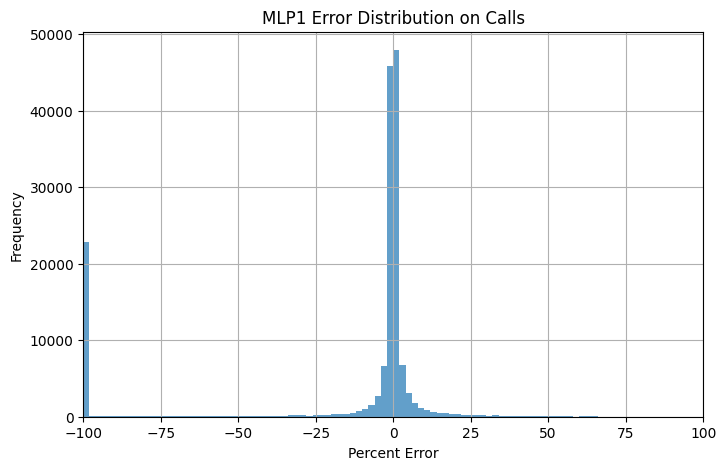

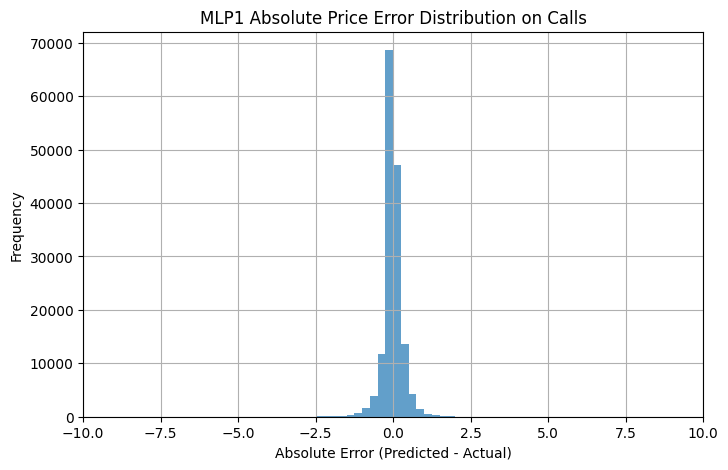

In [26]:
# Test 10 random entries
loaded_model = load_model(model_file)
sample_entries = X.sample(10)
sample_scaled = scaler.transform(sample_entries)
predictions = loaded_model.predict(sample_scaled)

for i, idx in enumerate(sample_entries.index):
    print(f"Entry {idx} - Predicted price: {predictions[i][0]:.2f}, Actual price: {y.loc[idx]:.2f}")

# ---- Full Test Set Error Analysis ----
X_test_scaled = scaler.transform(X_test)
y_pred = loaded_model.predict(X_test_scaled).flatten()
y_true = y_test.values

# Compute percent errors
percent_errors = 100 * (y_pred - y_true) / y_true

bins = np.arange(-200, 201, 2)  # from -100 to +100 with 2% width

# Plot histogram with x-axis limited to [-100%, 100%]
plt.figure(figsize=(8, 5))
plt.hist(percent_errors, bins=bins, alpha=0.7)
plt.xlabel("Percent Error")
plt.ylabel("Frequency")
plt.title("MLP1 Error Distribution on Calls")
plt.xlim([-100, 100])
plt.grid(True)
plt.show()

# ---- Absolute Error Analysis ----
abs_errors = y_pred - y_true

# Plot histogram of absolute errors
plt.figure(figsize=(8, 5))
plt.hist(abs_errors, bins=np.arange(-10, 10.25, 0.25), alpha=0.7)
plt.xlabel("Absolute Error (Predicted - Actual)")
plt.ylabel("Frequency")
plt.xlim([-10, 10])
plt.title("MLP1 Absolute Price Error Distribution on Calls")
plt.grid(True)
plt.show()

# Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt

# Pre-Processing

In [ ]:
# Load and combine data
PATH_TO_FILE_1 = "../raw data/aapl_2016_2020.csv"
PATH_TO_FILE_2 = "../raw data/aapl_2021_2023.csv"
half_1 = pd.read_csv(PATH_TO_FILE_1, low_memory=False)
half_2 = pd.read_csv(PATH_TO_FILE_2, low_memory=False)
df = pd.concat([half_1, half_2], ignore_index=True)
df.columns = df.columns.str.strip()

# Option type
option_type = "call"

# Convert Unix timestamps to datetime
df['QUOTE_DATETIME'] = pd.to_datetime(df['[QUOTE_UNIXTIME]'], unit='s')
df['EXPIRE_DATETIME'] = pd.to_datetime(df['[EXPIRE_UNIX]'], unit='s')

# Load underlying price data for volatility computation
underlying_prices = df[['QUOTE_DATETIME', '[UNDERLYING_LAST]']].drop_duplicates().set_index('QUOTE_DATETIME').sort_index()

# Function to compute historical volatility
def historical_volatility(series, window=20):
    return np.sqrt(252) * series.pct_change().rolling(window=window).std()

# Compute 20-day historical volatility
underlying_prices['hist_vol_20d'] = historical_volatility(underlying_prices['[UNDERLYING_LAST]'])
underlying_prices.dropna(inplace=True)

# Merge historical volatility back into main dataframe
df = df.merge(underlying_prices[['hist_vol_20d']], left_on='QUOTE_DATETIME', right_index=True, how='inner')

# Columns to numeric conversion: choose columns based on option type
if option_type == 'call':
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
                    '[C_THETA]', '[C_RHO]', '[C_BID]', '[C_ASK]']
else:
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]',
                    '[P_THETA]', '[P_RHO]', '[P_BID]', '[P_ASK]']

essential_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d', '[C_BID]', '[C_ASK]']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=essential_cols, inplace=True)

# Calculate mid-price based on option type
if option_type == 'call':
    df['CALL_EQUI_PRICE'] = (df['[C_BID]'] + df['[C_ASK]']) / 2
else:
    df['PUT_EQUI_PRICE'] = (df['[P_BID]'] + df['[P_ASK]']) / 2

# Drop rows with missing essential data (dynamically chosen based on option type)
essential_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d']
if option_type == 'call':
    essential_cols.append('CALL_EQUI_PRICE')
else:
    essential_cols.append('PUT_EQUI_PRICE')
df.dropna(subset=essential_cols, inplace=True)

# Prepare option data based on the option type
if option_type == 'call':
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]', '[C_THETA]', '[C_RHO]', 'CALL_EQUI_PRICE']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'equilibrium_price']
    output_file = 'processed_calls_data.csv'
    model_file = 'call-mlp1.h5'
else:
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]', '[P_THETA]', '[P_RHO]', 'PUT_EQUI_PRICE']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'equilibrium_price']
    output_file = 'processed_puts_data.csv'
    model_file = 'put-mlp1.h5'

option_df = df[option_cols].copy()
option_df.columns = col_rename

# Normalize strike price and compute time to expiry in years
option_df['strike_price'] = option_df['strike_price'] / 1000
option_df['time_to_expiry'] = option_df['days_to_expiry'] / 365
option_df.drop('days_to_expiry', axis=1, inplace=True)

print(option_df.sample(10))

         underlying_price  strike_price  hist_volatility    delta    gamma  \
1020405            147.02        0.1700         0.385578  0.40081  0.00892   
463782             167.96        0.0450         0.166906  0.84606  0.00001   
898426             166.87        0.1350         0.200893  1.00000  0.00000   
157236             123.25        0.2250         0.247939  0.04869  0.00251   
695125             112.11        0.1030         0.202977  0.94187  0.00938   
979529             460.03        0.3100         0.496036  0.84507  0.00084   
546928             190.89        0.1900         0.157796  0.54535  0.03901   
1335101            142.80        0.0600         0.197134  0.86801  0.00009   
1030873            151.55        0.1490         0.224935  0.59025  0.02423   
743444              96.76        0.0865         0.258076  1.00000  0.00000   

            vega    theta       rho  equilibrium_price  time_to_expiry  
1020405  0.55112 -0.02784   0.45582             10.525        0.9397

# Hyperparameters

In [ ]:
# Hyperparameters
n_units_per_layer = [256, 32, 1]
layers = 3
n_batch = 1024
n_epochs = 50

# Building model

In [ ]:
# Prepare data for modeling
X = option_df[['underlying_price', 'strike_price', 'hist_volatility', 'delta', 'gamma', 'vega', 'theta', 'rho', 'time_to_expiry']]
y = option_df['equilibrium_price']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create model 
model = Sequential()


# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add first layer without ativation
model.add(Dense(n_units_per_layer[0], input_shape=(X_train_scaled.shape[1],)))
model.add(Activation('relu'))

# Define Keras MLP model using LeakyReLU in subsequent layers
for i in range(1, layers - 1):
    model.add(Dense(n_units_per_layer[i]))
    model.add(Activation('relu'))

# Add last layer
model.add(Dense(n_units_per_layer[-1]))
model.add(Activation('relu'))

# Learning rate scheduling
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.1  # reduce LR by 10x every 10 epochs
    return lr

lr_callback = LearningRateScheduler(scheduler)

early_stop = EarlyStopping(
    monitor='val_loss',       # what to monitor
    patience=5,               # how many epochs to wait before stopping
    restore_best_weights=True,  # restores weights from best epoch
    verbose=1
)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,817 (42.25 KB)

 Trainable params: 10,817 (42.25 KB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [ ]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=n_batch, validation_split=0.2, verbose=1, callbacks=[lr_callback, early_stop])

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {mae}")

# Save the model
model.save(model_file)

Epoch 1/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 964.6230 - mae: 13.6452 - val_loss: 3.0790 - val_mae: 1.1061 - learning_rate: 0.0010
Epoch 2/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6403 - mae: 0.9618 - val_loss: 1.8566 - val_mae: 0.6823 - learning_rate: 0.0010
Epoch 3/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7386 - mae: 0.6311 - val_loss: 1.1885 - val_mae: 0.4847 - learning_rate: 0.0010
Epoch 4/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1653 - mae: 0.4599 - val_loss: 0.9821 - val_mae: 0.4055 - learning_rate: 0.0010
Epoch 5/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9109 - mae: 0.3788 - val_loss: 0.7839 - val_mae: 0.3359 - learning_rate: 0.0010
Epoch 6/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9095 - mae: 0.3364 - val_loss: 0.7578 - val_mae: 0.3273 - learning_rate: 0.0010
Epoch 7/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7017 - mae: 0.3035 - val_loss: 0.6686 - val_mae: 0.2752 - learning_ra

Test MAE: 0.19785672426223755


# Plot the loss

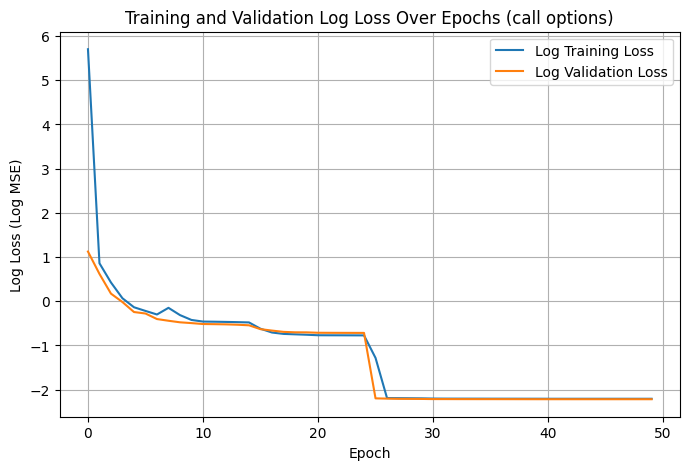

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8,5))

eps = 1e-10  # tiny number to avoid log(0)
plt.plot(np.log(np.array(history.history['loss']) + eps), label='Log Training Loss')
plt.plot(np.log(np.array(history.history['val_loss']) + eps), label='Log Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss (Log MSE)')
plt.title(f'Training and Validation Log Loss Over Epochs ({option_type} options)')
plt.legend()
plt.grid(True)
plt.show()

# Plot results

4843/4843 ━━━━━━━━━━━━━━━━━━━━ 2s 335us/step


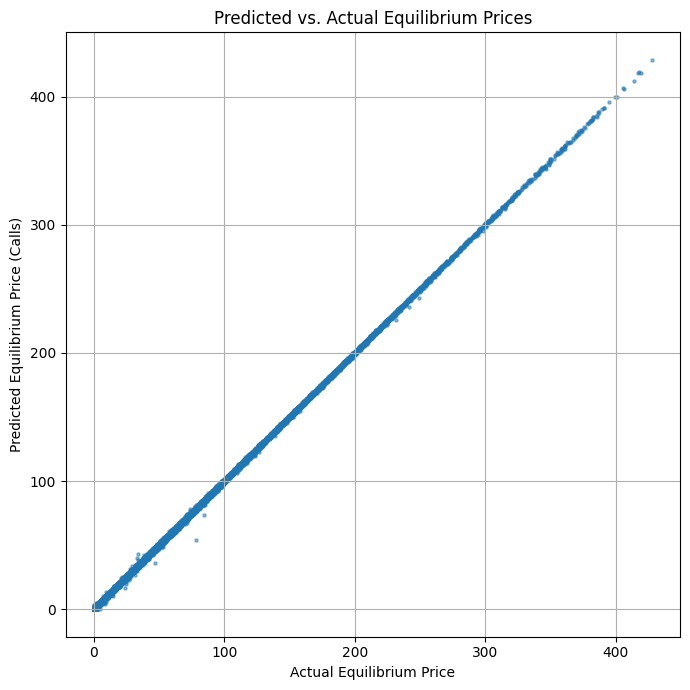

In [ ]:
loaded_model = load_model(model_file)

# Predict on test set
y_pred = model.predict(X_test_scaled).flatten()

# Align y_test to numpy array with matching shape
y_test_array = y_test.to_numpy().flatten()

# Plot predicted vs actual
plt.figure(figsize=(7, 7))
plt.scatter(y_test_array, y_pred, s=5, alpha=0.5)
plt.xlabel('Actual Equilibrium Price')
plt.ylabel('Predicted Equilibrium Price (Calls)')
plt.title('Predicted vs. Actual Equilibrium Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

# Test random entries

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Entry 1269307 - Predicted price: 22.75, Actual price: 22.88
Entry 862895 - Predicted price: 9.80, Actual price: 9.68
Entry 1219365 - Predicted price: 3.81, Actual price: 3.79
Entry 389144 - Predicted price: 0.00, Actual price: 0.34
Entry 80267 - Predicted price: 15.05, Actual price: 15.05
Entry 682005 - Predicted price: 14.31, Actual price: 13.23
Entry 1474730 - Predicted price: 3.49, Actual price: 3.71
Entry 1290077 - Predicted price: 18.46, Actual price: 18.65
Entry 526711 - Predicted price: 7.92, Actual price: 7.99
Entry 1489213 - Predicted price: 0.30, Actual price: 0.21
4843/4843 ━━━━━━━━━━━━━━━━━━━━ 2s 330us/step


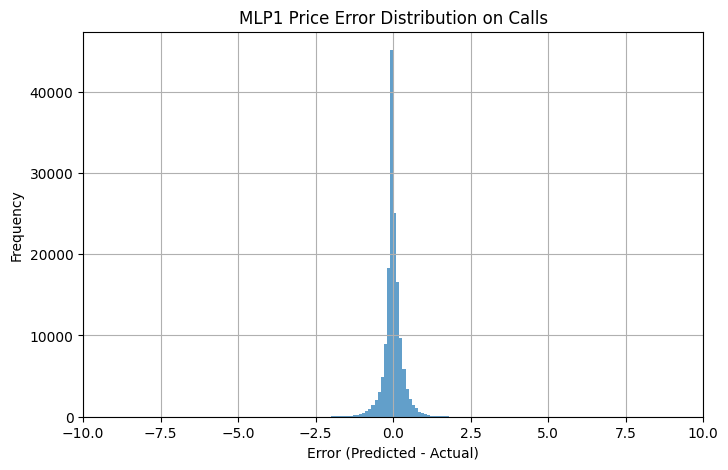

In [54]:
# Test 10 random entries
loaded_model = load_model(model_file)
sample_entries = X.sample(10)
sample_scaled = scaler.transform(sample_entries)
predictions = loaded_model.predict(sample_scaled)

for i, idx in enumerate(sample_entries.index):
    print(f"Entry {idx} - Predicted price: {predictions[i][0]:.2f}, Actual price: {y.loc[idx]:.2f}")

# ---- Full Test Set Error Analysis ----
X_test_scaled = scaler.transform(X_test)
y_pred = loaded_model.predict(X_test_scaled).flatten()
y_true = y_test.values
# ---- Absolute Error Analysis ----
abs_errors = y_pred - y_true

# Plot histogram of absolute errors
plt.figure(figsize=(8, 5))
plt.hist(abs_errors, bins=np.arange(-10, 10.1, 0.1), alpha=0.7)
plt.xlabel("Error (Predicted - Actual)")
plt.ylabel("Frequency")
plt.xlim([-10, 10])
plt.title("MLP1 Price Error Distribution on Calls")
plt.grid(True)
plt.show()

# Calculate error

In [ ]:
model_file = "call-mlp1-best-run-loss-0-1110.h5"
loaded_model = load_model(model_file)
y_pred = loaded_model.predict(X_test_scaled).flatten()

# Calculate errors
errors = y_test - y_pred

# Metrics
mean_error = np.mean(errors)
std_error = np.std(errors)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
max_err = np.min(errors)  # Negative max error (worst underprediction)
min_err = np.max(errors)  # Worst overprediction
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Error: {mean_error:.4f}")
print(f"Standard Deviation of Error: {std_error:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Max Error: {min_err:.4f}")
print(f"Min Error: {max_err:.4f}")
print(f"R² Score: {r2:.4f}")


# Create a mask to filter out zero or near-zero actual prices
valid_mask = np.abs(y_true) > 0

# Apply the mask
y_true_valid = y_true[valid_mask]
y_pred_valid = y_pred[valid_mask]

# Now calculate percent errors without worrying about divide-by-zero
abs_percent_errors = 100 * np.abs((y_pred_valid - y_true_valid) / y_true_valid)

# PE metrics
def compute_pe(abs_percent_errors, threshold):
    return np.mean(abs_percent_errors <= threshold) * 100
# Compute standard deviation of absolute percent errors
std_e = np.std(errors)
std_ape = np.std(abs_percent_errors)

print(f"Filtered sample size: {len(y_true_valid)}")
print(f"PE5:  {compute_pe(abs_percent_errors, 5):.2f}%")
print(f"PE10: {compute_pe(abs_percent_errors, 10):.2f}%")
print(f"PE20: {compute_pe(abs_percent_errors, 20):.2f}%")
print(f"Standard Deviation of errors: {std_e:.2f}")
print(f"Standard Deviation of APE: {std_ape:.2f}%")

4843/4843 ━━━━━━━━━━━━━━━━━━━━ 2s 317us/step
Mean Error: 0.0060
Standard Deviation of Error: 0.3332
Mean Absolute Error (MAE): 0.1979
Root Mean Squared Error (RMSE): 0.3332
Max Error: 24.5784
Min Error: -9.0400
R² Score: 0.9999
[0.25890262 2.78288247 0.34793117 ... 0.09037461 8.63904504 1.45975871]
Filtered sample size: 154307
PE5:  71.55%
PE10: 76.69%
PE20: 80.06%
Standard Deviation of errors: 0.33
Standard Deviation of APE: 75.15%


# Calculate error

In [50]:
model_file = "call-mlp1-best-run-loss-0-1110.h5"
loaded_model = load_model(model_file)
y_pred = loaded_model.predict(X_test_scaled).flatten()

# Calculate errors
errors = y_test - y_pred

# Metrics
mean_error = np.mean(errors)
std_error = np.std(errors)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
max_err = np.min(errors)  # Negative max error (worst underprediction)
min_err = np.max(errors)  # Worst overprediction
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Error: {mean_error:.4f}")
print(f"Standard Deviation of Error: {std_error:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


# Create a mask to filter out zero or near-zero actual prices
valid_mask = np.abs(y_true) > 0

# Apply the mask
y_true_valid = y_true[valid_mask]
y_pred_valid = y_pred[valid_mask]

# Now calculate percent errors without worrying about divide-by-zero
abs_percent_errors = 100 * np.abs((y_pred_valid - y_true_valid) / y_true_valid)

# PE metrics
def compute_pe(abs_percent_errors, threshold):
    return np.mean(abs_percent_errors <= threshold) * 100

# Compute standard deviation of absolute percent errors
std_e = np.std(errors)
print(f"PE5:  {compute_pe(abs_percent_errors, 5):.2f}%")
print(f"PE10: {compute_pe(abs_percent_errors, 10):.2f}%")
print(f"PE20: {compute_pe(abs_percent_errors, 20):.2f}%")

4843/4843 ━━━━━━━━━━━━━━━━━━━━ 2s 313us/step
Mean Error: 0.0060
Standard Deviation of Error: 0.3332
Mean Absolute Error (MAE): 0.1979
Root Mean Squared Error (RMSE): 0.3332
PE5:  71.55%
PE10: 76.69%
PE20: 80.06%
